Side note: we are evaluating particle level information
maybe we should also do the event level information

In [1]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
print(date)

2024-12-02


In [2]:
!pip install -e ../../../. --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-awkward 2024.7.0 requires awkward>=2.5.1, but you have awkward 1.10.5 which is incompatible.


In [3]:
!pip install --upgrade awkward --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
coffea 0.7.20 requires awkward<2,>=1.5.1, but you have awkward 2.7.1 which is incompatible.


In [4]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

In [5]:
from src.analysis.resolved import parse_resolved_w_target
from src.analysis.utils import calc_eff, calc_pur 

/Users/billyli/miniforge_x86_new/envs/spanet/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [6]:
target_path = '/Users/billyli/UCSD/hhh/reports/bv2_2h/hh_testing.h5'

In [7]:
baseline_path = "//Users/billyli/UCSD/hhh/reports/bv2_2h/mix_baseline_bdt_loose_hh.h5"
r_path = "/Users/billyli/UCSD/hhh/reports/benchmark/HH_resolved/1118.h5"

In [8]:
baseline_h5 = h5.File(baseline_path, "a")
r_h5 = h5.File(r_path, "a")
target_h5 = h5.File(target_path)

In [9]:
if "TARGETS" not in r_h5.keys():
    r_h5["INPUTS"] = r_h5["SpecialKey.Inputs"]
    r_h5["TARGETS"] = r_h5["SpecialKey.Targets"]

In [10]:
LUT_resolved_pred_bl, LUT_resolved_target_bl, _ = parse_resolved_w_target(target_h5, baseline_h5, fjs_reco=None, num_higgs=2) 
LUT_resolved_pred_r, LUT_resolved_target_r, _ = parse_resolved_w_target(target_h5, r_h5, fjs_reco=None, num_higgs=2) 

In [11]:
bins = np.arange(0, 1050, 50)
plot_bins = np.append(bins, 2 * bins[-1] - bins[-2]) 
bin_centers = [(plot_bins[i] + plot_bins[i + 1]) / 2 for i in range(plot_bins.size - 1)] 
xerr = (plot_bins[1] - plot_bins[0]) / 2 * np.ones(plot_bins.shape[0] - 1)

In [12]:
bl_eff, bl_eff_err, bl_avg_eff, bl_n_reco_target = calc_eff(None, LUT_resolved_target_bl, bins)
bl_pur, bl_pur_err, bl_avg_pur, bl_n_correct_pred = calc_pur(None, LUT_resolved_pred_bl, bins)

In [13]:
r_eff, r_eff_err, r_avg_eff, r_n_reco_target = calc_eff(None, LUT_resolved_target_r, bins)
r_pur, r_pur_err, r_avg_pur, r_n_correct_pred = calc_pur(None, LUT_resolved_pred_r, bins)

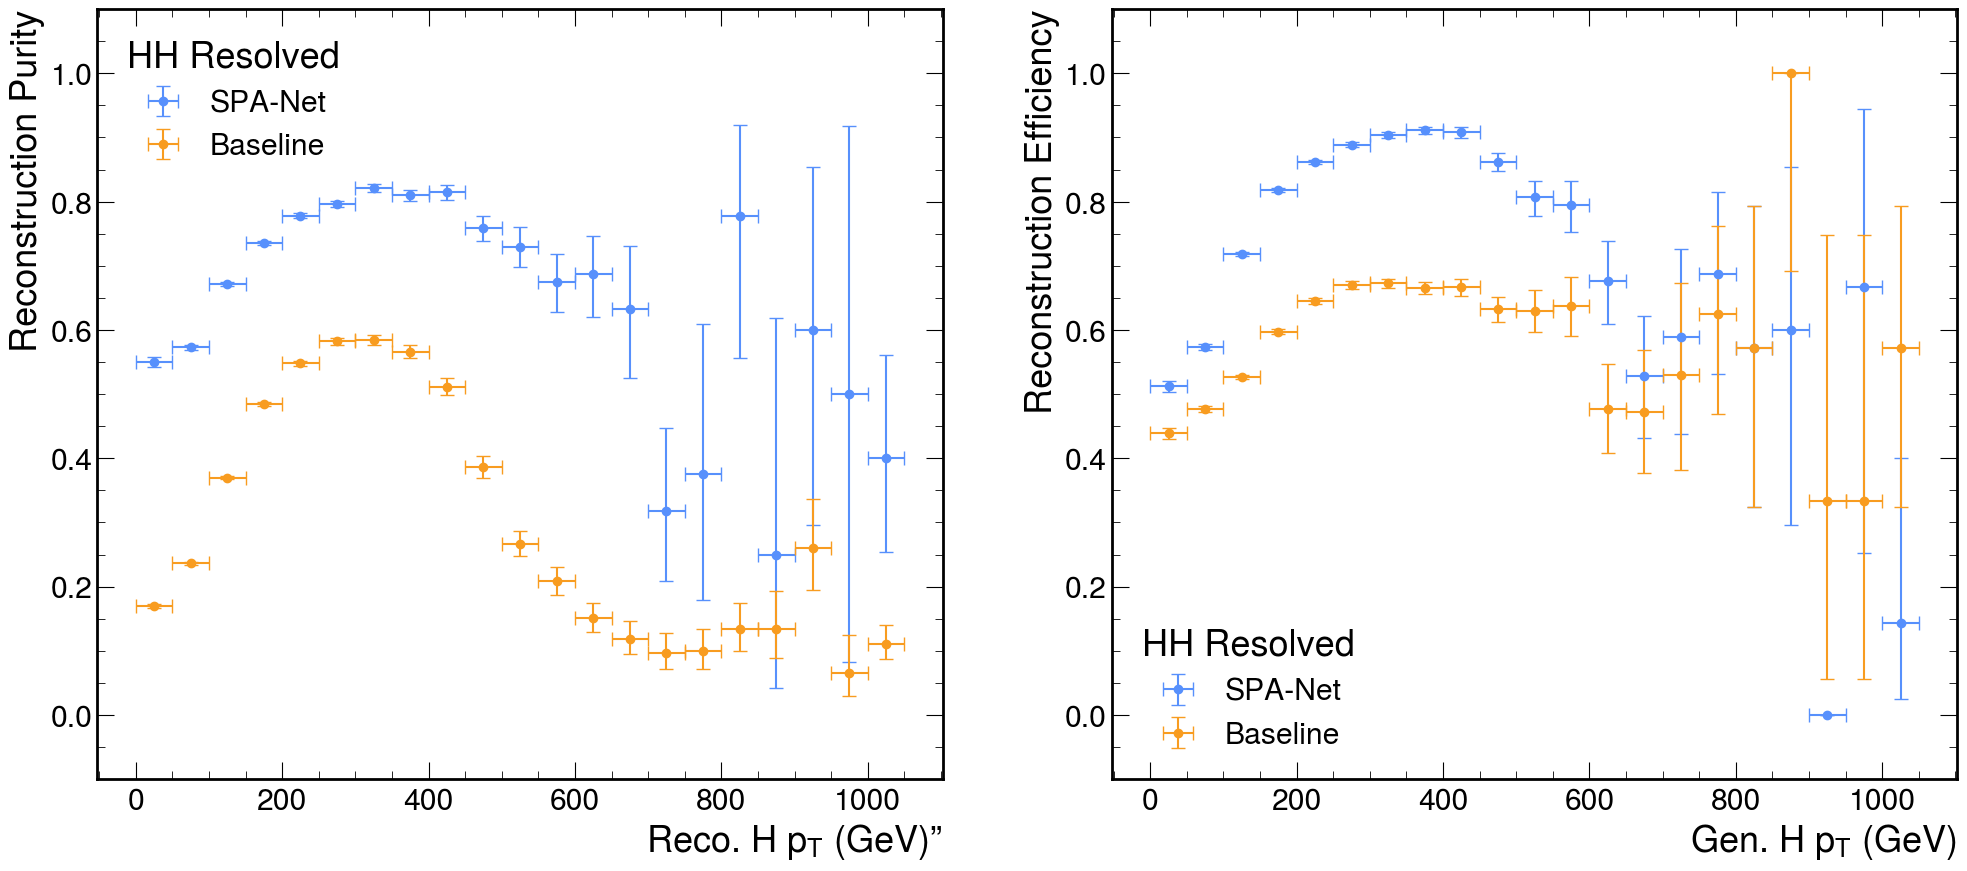

In [14]:
fig_r, ax_r = plt.subplots(1, 2, figsize=(24, 10))
ax_r[0].set(
          xlabel=r"Reco. H $p_\mathrm{T}$ (GeV)”",
          ylabel=r"Reconstruction Purity",
#           title=f"Reconstruction Purity vs. Reco Resolved H pT",
)   
ax_r[1].set(
          xlabel=r"Gen. H $p_\mathrm{T}$ (GeV)",
          ylabel=r"Reconstruction Efficiency",
#           title=f"Reconstruction Efficiency vs. Gen Resolved H pT",
)   

ax_r[0].errorbar(
           x=bin_centers, y=r_pur, xerr=xerr, yerr=r_pur_err, fmt="o", capsize=5, label='SPA-Net'
)
ax_r[1].errorbar(
            x=bin_centers, y=r_eff, xerr=xerr, yerr=r_eff_err, fmt="o", capsize=5, label='SPA-Net'
)

ax_r[0].errorbar(
           x=bin_centers, y=bl_pur, xerr=xerr, yerr=bl_pur_err, fmt="o", capsize=5, label='Baseline'
)
ax_r[1].errorbar(
            x=bin_centers, y=bl_eff, xerr=xerr, yerr=bl_eff_err, fmt="o", capsize=5, label='Baseline'
)



ax_r[0].legend(title='HH Resolved')
ax_r[1].legend(title='HH Resolved')
ax_r[0].set(ylim=[-0.1, 1.1])
ax_r[1].set(ylim=[-0.1, 1.1])
fig_r.savefig(f"/Users/billyli/Documents/SPANet/SPANet_results/HH/R/{date}_west.pdf", format='pdf')

In [15]:
print("SPANet Average purity:", r_avg_pur)
print("Baseline Average purity:", bl_avg_pur)

SPANet Average purity: 0.7021785245294454
Baseline Average purity: 0.38959565339826735


In [16]:
print("SPANet Average efficiency:", r_avg_eff)
print("Baseline Average efficiency:", bl_avg_eff)

SPANet Average efficiency: 0.7692364441165621
Baseline Average efficiency: 0.57837206442887


In [17]:
print("SPANet Number of correct Higgs candidate predictions:", r_n_correct_pred)
print("Baseline Number of correct Higgs candidate predictions:", bl_n_correct_pred)

SPANet Number of correct Higgs candidate predictions: 62562.0
Baseline Number of correct Higgs candidate predictions: 47039.0


In [18]:
print("SPANet Number of reconstructed Higgs targets:", r_n_reco_target)
print("Baseline Number of reconstructed Higgs targets:", bl_n_reco_target)

SPANet Number of reconstructed Higgs targets: 62562.0
Baseline Number of reconstructed Higgs targets: 47039.0
